In [1]:
!pip install hmmlearn

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 123.8/123.8 kB 1.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('weatherHistory.csv')
#setting the dataframe index
df.set_index("Formatted Date", inplace=True)

In [4]:
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
Formatted Date,,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Pre processing
Checking nas

In [6]:
print(df.isnull().sum())
print(len(df))
#there are 517 null values in the Precip Type column
#dropping the column
df.drop('Precip Type', axis=1, inplace=True)

Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64
96453


In [9]:
from sklearn.preprocessing import LabelEncoder

#Initiate the labelEncoder
label_encoder = LabelEncoder()

#Fit and transform the data
df['Summary'] = label_encoder.fit_transform(df['Summary'])

#Since summary and Daily summary are the same
df.drop('Daily Summary', axis=1, inplace=True)


In [10]:
#Check the loud Cover
df['Loud Cover'].describe()

count    96453.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Loud Cover, dtype: float64

In [11]:
df.drop('Loud Cover', axis=1, inplace=True)

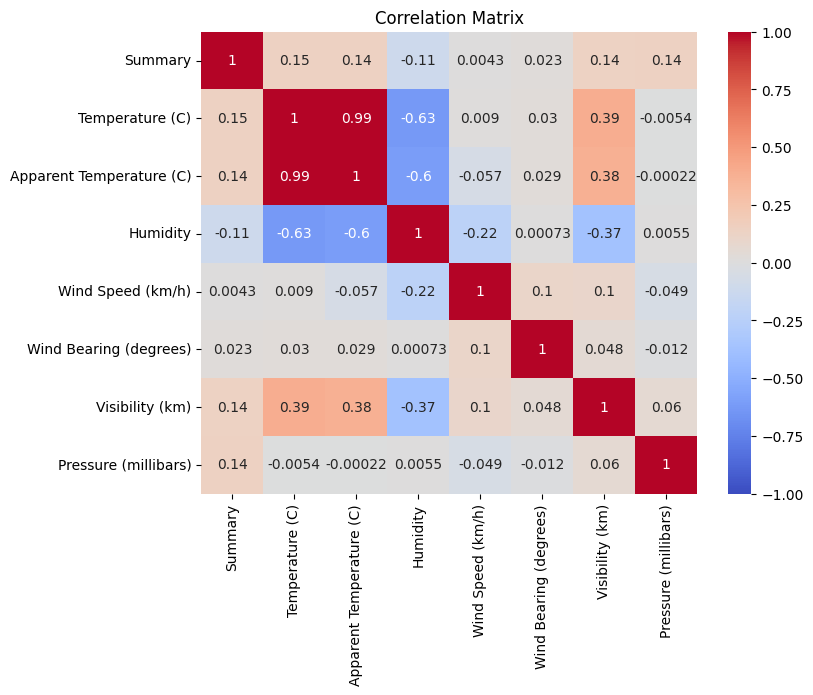

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [15]:
#Temperature is ~~ Temperature apparente so we are going to drop the Apparente Temperature
df.drop('Apparent Temperature (C)', axis=1, inplace=True)

In [16]:
from sklearn.model_selection import train_test_split
# Assuming you have your features (X) and target (y) data ready
y = df['Summary']
df.drop('Summary' , axis = 1 , inplace = True)

In [17]:
X = df

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier( min_samples_split = 22,random_state=1)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [20]:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)

0.5812036701052304

In [21]:
#Trying the HMM
from hmmlearn import hmm
# Define the HMM model
n_components = len(set(y))  # Number of hidden states (based on unique summary labels)
model = hmm.GaussianHMM(n_components=n_components, covariance_type="full")

In [22]:
# Train the HMM model on the training data
model.fit(X_train)

# Predict the most likely hidden states (i.e., weather conditions) on the test data
predicted_states = model.predict(X_test)

In [23]:
print(predicted_states)
print(y_test)

[ 2 22  2 ...  2 26 12]
Formatted Date
2015-09-19 17:00:00.000 +0200    17
2009-11-29 14:00:00.000 +0100    17
2006-11-18 16:00:00.000 +0100    17
2010-02-10 20:00:00.000 +0100    18
2006-01-14 16:00:00.000 +0100    17
                                 ..
2016-11-12 13:00:00.000 +0100    17
2012-07-04 03:00:00.000 +0200     6
2007-04-20 08:00:00.000 +0200    19
2011-07-22 17:00:00.000 +0200    19
2010-09-02 17:00:00.000 +0200    17
Name: Summary, Length: 19291, dtype: int64
